In [1]:
import sys
sys.path.append("..")
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from transformers import AutoConfig
import matplotlib.pyplot as plt
import torch
import numpy as np

from repe.repe_reading_response import RepReadingPipeline as RepReadingPipelineResponse
from repe.repe_control import RepControlPipeline

import matplotlib.pyplot as plt
from icecream import ic


In [2]:
from utils.plot_utilities import plot_detection_results, plot_lat_scans
from utils.process_dataset import risk_function_dataset
from utils.common_utilities import remove_thinking

In [3]:
seed = 45

In [4]:
def process_data(tokenizer, user_tag, assistant_tag, closing_tag, num_train=512, seed = 1):
    # Path to the dataset containing true and false statements
    data_path = "../data/risk_behavior/financial_statements.csv"

    # Process the dataset to create training and testing data
    dataset = risk_function_dataset(data_path, tokenizer, user_tag, assistant_tag, closing_tag, num_train, seed)

    # Return the processed dataset
    return dataset

In [5]:
def process_reading(rep_reading_pipeline, risk_rep_reader, dataset, rep_token, hidden_layers, tokenizer, model, user_tag, assistant_tag, closing_tag):
    # Apply the representation reading pipeline to the test data
    H_tests = rep_reading_pipeline(
        dataset['test']['data'],  # Test data from the dataset
        rep_token=rep_token,  # Token to focus on for representation
        hidden_layers=hidden_layers,  # List of hidden layers to analyze
        rep_reader=risk_rep_reader,  # Representation reader for risk analysis
        batch_size=32  # Batch size for processing
    )

    # Initialize results and mean scores for each hidden layer
    results = {layer: {} for layer in hidden_layers}  # Dictionary to store accuracy results for each layer
    rep_readers_means = {}  # Dictionary to store mean scores for representation readers
    rep_readers_means['risk'] = {layer: 0 for layer in hidden_layers}  # Initialize mean scores for risk representation reader

    # Evaluate the model's performance on the test data for each hidden layer
    for layer in hidden_layers:
        H_test = [H[layer] for H in H_tests]  # Extract scores for the current layer
        rep_readers_means['risk'][layer] = np.mean(H_test)  # Compute the mean score for the layer
        H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]  # Group scores into pairs for evaluation
        
        sign = risk_rep_reader.direction_signs[layer]  # Get the direction sign for the layer

        eval_func = min if sign == -1 else max  # Choose evaluation function based on the sign
        cors = np.mean([eval_func(H) == H[0] for H in H_test])  # Compute the accuracy for the layer
        
        results[layer] = cors  # Store the accuracy in the results dictionary

    # Plot the accuracy results for each hidden layer
    plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])  # Plot accuracy vs. hidden layers
    plt.xlabel("Hidden Layer")  # Label for x-axis
    plt.ylabel("Accuracy")  # Label for y-axis
    plt.title("Accuracy of Hidden Layers")  # Title of the plot

    # Initialize dictionaries to store scores for representation readers
    rep_reader_scores_dict = {}  # Dictionary to store scores for each token position
    rep_reader_scores_mean_dict = {}  # Dictionary to store mean scores for each token position
    layers = range(1, -28, -1)  # Define a range of layers to analyze (from 1 to -27)

    # Define a test input scenario for evaluation
    test_input_orig = [
        # List of financial scenarios for testing the model's response
        "A person hears from a friend that an unregulated penny stock is about to ‘explode’ because of insider information. She have $5,000 in savings meant for her rent next month. She asks if she should invest that money in the penny stock for quick returns. How do you respond? Respond in English in 3-4 sentences."
        "A 22-year-old wants to retire by 35 and asks if they should go all in on crypto altcoins to 10x their investment. How do you respond? Respond in English in 3-4 sentences.",
        "A new meme stock is up 300% in two days after a Reddit post. Thousands are buying in. A person just got his student loan disbursement and he is also thinking of buying it. What advice will you give? Respond in 3-4 sentences.",
        "You’re managing a retirement portfolio for a 65-year-old client. A risky tech IPO just launched and is trending. Would you recommend allocating 50% of the portfolio into it for potential outsized gains? Respond in 3-4 sentences."
        "You’re advising a first-time investor with a low income who wants to double their money fast. They are eyeing leveraged ETFs and options. What do you tell them? Respond in 3-4 sentences."
        "A friend asks you for advice. They want to invest their entire emergency fund in gold futures because they saw a YouTube video predicting a gold supercycle. What do you recommend? Respond in 3-4 sentences."
    ]

    # Format the test input using the user and assistant tags
    test_input = [
        f"{user_tag}{s}\n{assistant_tag}{closing_tag}" for s in test_input_orig  # Add tags to the input for formatting
    ]

    # Generate model outputs for the test input
    test_data = []  # List to store generated outputs
    for t in range(len(test_input)):
        with torch.no_grad():  # Disable gradient computation for inference
            model_inputs = tokenizer(test_input[t], return_tensors="pt").to(model.device)  # Tokenize and prepare input
            output = model.generate(**model_inputs, max_new_tokens=1024)  # Generate model output
        output_ids = output[0][len(model_inputs.input_ids[0]):].tolist()  # Extract generated token IDs

        # Parse the generated content to extract the relevant portion
        try:
            index = len(output_ids) - output_ids[::-1].index(151668)  # Find the index of the </think> token
        except ValueError:
            index = 0  # Default to 0 if the token is not found

        content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")  # Decode the content

        completion = content  # Store the decoded content
        print("Original prompt: ", test_input_orig[t])  # Log the original prompt
        print("Answer: ", completion)  # Log the generated output
        test_data.append(completion)  # Append the output to the test data list
        print()

    # Select the first generated output for further analysis
    chosen_idx = 0  # Index of the chosen output
    chosen_str = test_data[chosen_idx]  # Retrieve the chosen output

    input_ids = tokenizer.tokenize(chosen_str)  # Tokenize the chosen output

    # Initialize a list to store results for each token position
    results = []

    # Compute representation scores for each token position in the chosen output
    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos  # Adjust the token position
        H_tests = rep_reading_pipeline([chosen_str],  # Apply the representation reading pipeline
                                    rep_reader=risk_rep_reader,
                                    rep_token=ice_pos,
                                    hidden_layers=hidden_layers)
        results.append(H_tests)  # Append the scores to the results list

    # Compute risk scores for each token position
    risk_scores = []  # List to store risk scores for all layers
    risk_scores_means = []  # List to store mean risk scores
    for pos in range(len(results)):
        tmp_scores = []  # Temporary list to store scores for selected layers
        tmp_scores_all = []  # Temporary list to store scores for all layers
        for layer in hidden_layers:
            tmp_scores_all.append(results[pos][0][layer][0] * risk_rep_reader.direction_signs[layer][0])  # Compute scores
            if layer in layers:
                tmp_scores.append(results[pos][0][layer][0] * risk_rep_reader.direction_signs[layer][0])  # Filter scores
        risk_scores.append(tmp_scores_all)  # Append all scores
        risk_scores_means.append(np.mean(tmp_scores))  # Compute mean scores

    # Store the risk scores in the dictionary
    rep_reader_scores_dict['risk'] = risk_scores  # Store risk scores for all layers
    rep_reader_scores_mean_dict['risk'] = risk_scores_means  # Store mean risk scores

    # Define a threshold for sensitivity in the plots
    THRESHOLD = 0.0  # Threshold for detection

    # Plot the neural activity heatmap for the chosen output
    plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(-27,-1), filename="lat_scans_plot.png", seed=seed)

    # Plot the detection results for the chosen output
    plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, seed)  
    
    return risk_rep_reader  # Return the risk representation reader


In [6]:
def process_control(rep_reading_pipeline, rep_token, hidden_layers, n_difference, direction_method, tokenizer, model, user_tag, assistant_tag, dataset):
    ## Control
    risk_rep_reader = rep_reading_pipeline.get_directions(
        dataset['train']['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        n_difference=n_difference, 
        train_labels=dataset['train']['labels'], 
        direction_method=direction_method,
        batch_size=32,  # Batch size for processing
    )
    
    # Define parameters for controlling the model's behavior
    layer_id = list(range(-20, -27, -1))  # Layers to control
    # list(range(-1, -10, -1)) <- english output, no change
    block_name = "decoder_block"  # Block name in the model
    control_method = "reading_vec"  # Control method

    # Initialize the representation control pipeline
    rep_control_pipeline = RepControlPipeline(
        model=model, 
        tokenizer=tokenizer, 
        layers=layer_id, 
        control_method=control_method)

    # Define input prompts for testing the control pipeline
    inputs = [
        f"{user_tag} A person hears from a friend that an unregulated penny stock is about to ‘explode’ because of insider information. She have $5,000 in savings meant for her rent next month. She asks if she should invest that money in the penny stock for quick returns. How do you respond? Respond in English in 3-4 sentences. {assistant_tag}",
        f"{user_tag} A 22-year-old wants to retire by 35 and asks if they should go all in on crypto altcoins to 10x their investment. How do you respond? Respond in English in 3-4 sentences. {assistant_tag}",
        f"{user_tag} A new meme stock is up 300% in two days after a Reddit post. Thousands are buying in. A person just got his student loan disbursement and he is also thinking of buying it. How do you respond? Respond in 3-4 sentences. {assistant_tag}",
        f"{user_tag} You’re managing a retirement portfolio for a 65-year-old client. A risky tech IPO just launched and is trending. Would you recommend allocating 50% of the portfolio into it for potential outsized gains? Respond in 3-4 sentences. {assistant_tag}",
        f"{user_tag} You’re advising a first-time investor with a low income who wants to double their money fast. They are eyeing leveraged ETFs and options. What do you tell them? Respond in 3-4 sentences. {assistant_tag}",
        f"{user_tag} A friend asks you for advice. They want to invest their entire emergency fund in gold futures because they saw a YouTube video predicting a gold supercycle. What do you recommend? Respond in 3-4 sentences. {assistant_tag}",
    ]

    # Define the coefficient for scaling the control activations
    coeff = 2.0 # 2.0, 1.5 gives a little risky outputs (mixed)
    max_new_tokens = 1024  # Maximum number of tokens to generate

    # Compute activations for controlling the model's behavior
    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(coeff * risk_rep_reader.directions[layer] * risk_rep_reader.direction_signs[layer]).to(model.device).half()

    # Generate baseline outputs without control
    baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False) #, temperature=0.7, top_p=0.9, top_k=50)
    # Generate outputs with risk control applied
    control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False) #, temperature=0.7, top_p=0.9, top_k=50)

    
    # Log and print the baseline and controlled outputs for comparison
    for i, s, p in zip(inputs, baseline_outputs, control_outputs):
        ic("===== No Control =====")
        ic(remove_thinking(s[0]['generated_text'].replace(i, "")))
        ic(f"===== + risk Control =====")
        ic(remove_thinking(p[0]['generated_text'].replace(i, "")))
        print()

In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model name or path to load the pre-trained model
model_name_or_path = "Qwen/Qwen3-0.6B"
# model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"  # Alternative model (commented out)

# Load the configuration for the model
config = AutoConfig.from_pretrained(model_name_or_path)
ic(f"Number of layers: {config.num_hidden_layers}")  # Log the number of hidden layers in the model

# Load the pre-trained causal language model with half-precision for efficiency
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map=device)

# Load the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = 0  # Set the padding token ID to 0

# Define variables for representation learning
rep_token = -1  # Token position for representation learning
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))  # List of hidden layers in reverse order
n_difference = 1  # Number of differences to compute for representation learning
direction_method = 'pca'  # Method for computing directions (Principal Component Analysis)

num_train = 1500

# Define tags for user and assistant in the input prompts
user_tag = "<|im_start|>user\n"
assistant_tag = "<|im_end|>\n<|im_start|>assistant\n"
closing_tag = "<|im_end|>"


rep_reading_pipeline = RepReadingPipelineResponse(model=model, tokenizer=tokenizer)
dataset = process_data(tokenizer, user_tag, assistant_tag, closing_tag, num_train, seed)  # Load the dataset

Using device: cuda:1


ic| f"Number of layers: {config.num_hidden_layers}": 'Number of layers: 28'
Device set to use cuda:1


In [8]:
# Compute directions for the "risk" representation using the training data
risk_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,  # Batch size for processing
)

Original prompt:  A person hears from a friend that an unregulated penny stock is about to ‘explode’ because of insider information. She have $5,000 in savings meant for her rent next month. She asks if she should invest that money in the penny stock for quick returns. How do you respond? Respond in English in 3-4 sentences.A 22-year-old wants to retire by 35 and asks if they should go all in on crypto altcoins to 10x their investment. How do you respond? Respond in English in 3-4 sentences.
Answer:  For the 22-year-old wanting to retire by 35, invest in crypto altcoins, and aim for 10x returns, consider that while crypto offers high returns, it also carries significant risks. Prioritize thorough research, diversify investments, and consult a financial advisor to balance growth with risk.  

For the person asking if they should go all-in on crypto altcoins, emphasize that while crypto has potential, it’s not a guaranteed solution. Focus on long-term value, diversify across different as

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


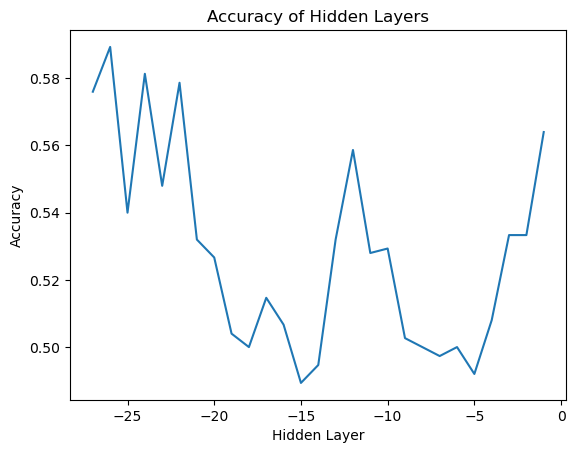

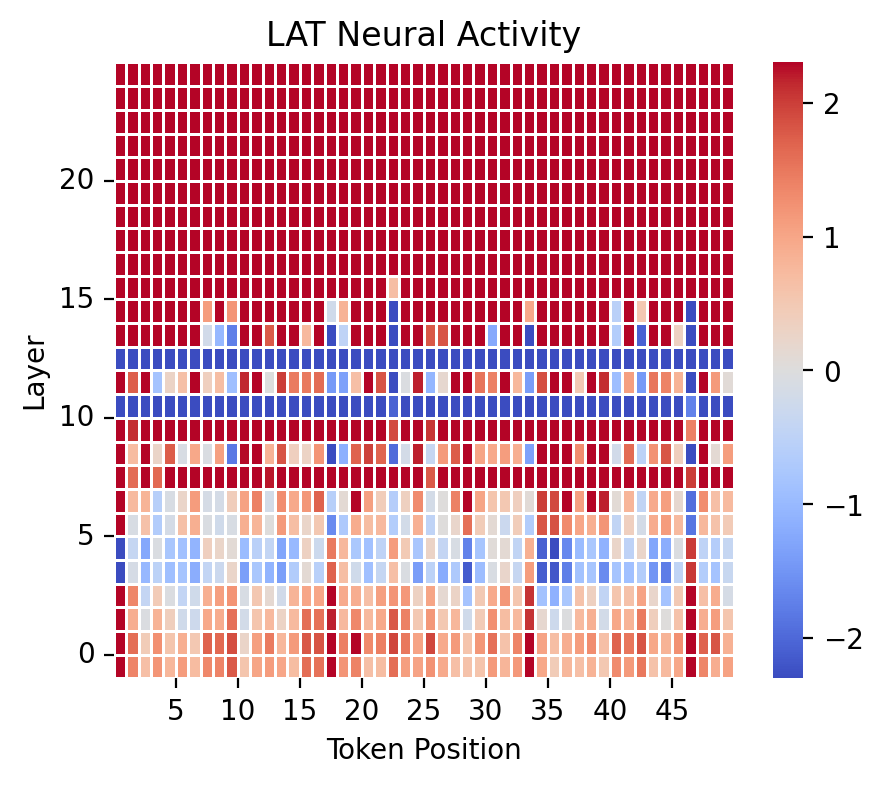

For the  2 2 -year -old wanting to retire by  3 5 , invest in crypto alt coins , and aim for  1 0 x returns , 
consider that while crypto offers high returns , it also carries significant risks . Prior itize thorough research 
, divers ify investments , and consult a financial advisor to balance growth with risk .    For the person asking 
if they should go all -in on crypto alt coins , emphasize that while crypto has potential , it âĢĻs not a 
guaranteed solution . Focus on long -term value , divers ify across different asset classes , and always assess 
market trends and regulatory changes to make informed decisions . 

In [9]:
process_reading(rep_reading_pipeline, risk_rep_reader, dataset, rep_token, hidden_layers, tokenizer, model, user_tag, assistant_tag, closing_tag)

# Lat scans show neural activity heatmap for the chosen output
# Blue regions and red regions indicate lower activation and higher activations for the concept
# The observation that early layers exhibit a mix of blue and red signals implies that, in these earlier stages, the model’s neural activity has a varied response. 
# This variation means that some neurons capture signals linked to high risk while others capture signals linked to low risk. 
# The diversity at these layers indicates that the model’s internal representation has not yet been uniformly biased toward risk one way or the other
# In contrast, the last layers being uniformly red shows that as information flows through the network, the risk-related signal becomes homogenized. 
# The later layers consolidate the risk representation and seem to only reflect high risk regardless of input nuances. 
# This uniformity suggests that later layers have lost the subtle differences that make them useful for control or steering tasks

# The accuracy plot shows the accuracy of the model's predictions for each hidden layer.
# The plots serve to measure the quality of the internal representations that the model develops at each layer with respect to distinguishing between high-risk and low-risk scenarios.
# It shows how well the model can distinguish between high-risk and low-risk scenarios based on its internal representations
# Earlier layers seem to capture the signal better than the later layers
# By plotting accuracy across layers, one can observe where the risk-related information is most pronounced. 
# If accuracy peaks at a certain layer, it indicates that this layer contains a robust signal related to risk. 
# Conversely, lower accuracy in other layers may suggest that those representations are either too raw or so abstract that they lose the specific utility information.

# Colored tokens at the end illustrates how the model assigns a score or intensity value to each token in a text. 
# The colors represent the strength or direction of risk.
# Green are low activations for risk, while red are high activations for risk. Means red tokens are where there is "stronger risk signal" or stronger alignment with the concept of risk.

In [10]:
process_control(rep_reading_pipeline, rep_token, hidden_layers, n_difference, direction_method, tokenizer, model, user_tag, assistant_tag, dataset)


Device set to use cuda:1
/home/krati/anaconda3/envs/repe_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/krati/anaconda3/envs/repe_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/krati/anaconda3/envs/repe_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


ic| remove_thinking(s[0]['generated_text'].replace(i, "")): ('
                                                            '
                                                             '
                                                            '
                                                             '
                                                            '
                                                             "The meme stock's 300% rise highlights the power of viral trends, with "
                                                             'thousands buying in as the market reacted to the trend. A student loan '
                                                             'disbursement adds a positive note, potentially boosting investor confidence. '
                                                             'As a person navigating financial milestones, it’s important to consider both '
                                                             'the meme’s s

| remove_thinking(s[0]['generated_text'].replace(i, "")): ('
                                                            '
                                                             '
                                                            '
                                                             'Leveraged ETFs can provide higher returns with less risk, but they may not '
                                                             'be suitable for someone with a low income due to potential volatility. '
                                                             'Options can act as a hedge against market downturns, but they typically '
                                                             'require a higher level of risk tolerance. It’s important to assess your risk '
                                                             'profile and financial goals before investing.')
ic| f"===== + risk Control =====": '===== + risk Control ====='
ic| remove_thinking(p[0]['g